In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2  # OpenCV library


In [32]:
# Load the Digits dataset
digits = load_digits()
X = digits.images
y = digits.target

# Function to preprocess images using OpenCV
def preprocess_image(image):
    # Convert image to uint8 for OpenCV
    image = (image * 255).astype(np.uint8)
    # Resize image if necessary (keeping the same size here, but you can adjust)
    image = cv2.resize(image, (8, 8))
    # Convert back to float32 and normalize
    image = image.astype(np.float32) / 255.0
    return image

In [33]:
# Preprocess images
X = np.array([preprocess_image(img) for img in X])

# Reshape images to include channel dimension
X = X.reshape(-1, 1, 8, 8).astype(np.float32)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [34]:
# Custom dataset class
class DigitsDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are of type long
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


In [35]:
# Data loaders
train_dataset = DigitsDataset(X_train, y_train)
test_dataset = DigitsDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [36]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
# Instantiate the model, define loss function and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [37]:
# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.long()  # Ensure labels are of type long
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


Epoch 1/5, Loss: 0.6889
Epoch 2/5, Loss: 0.4811
Epoch 3/5, Loss: 0.4275
Epoch 4/5, Loss: 0.3873
Epoch 5/5, Loss: 0.3340


In [38]:
# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        labels = labels.long()  # Ensure labels are of type long
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8917


In [39]:
# Visualize some images using matplotlib and OpenCV
def show_image(image):
    image = np.squeeze(image)  # Remove channel dimension for display
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

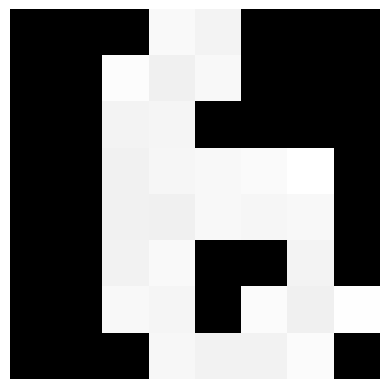

Label: 6


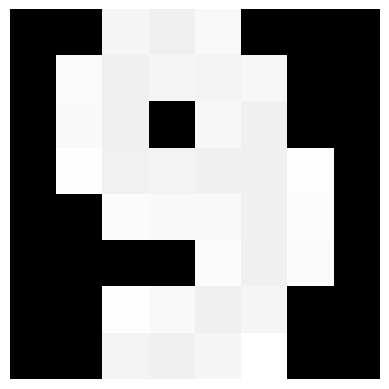

Label: 9


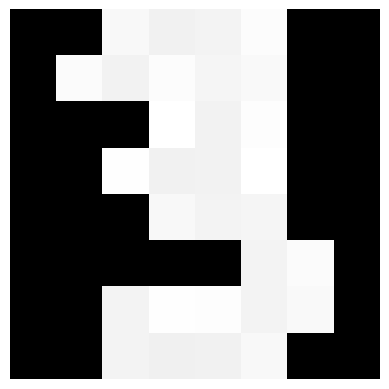

Label: 3


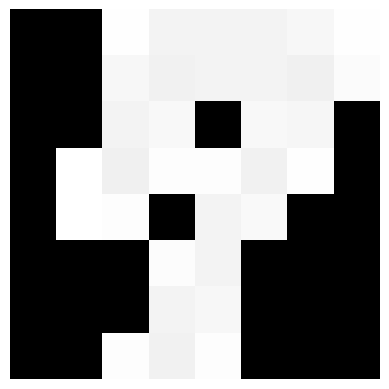

Label: 7


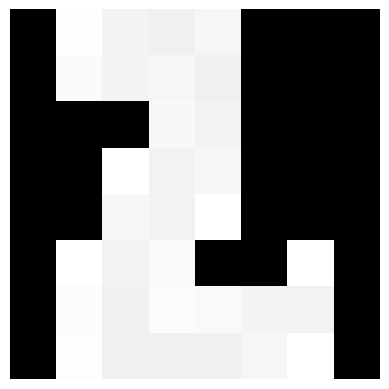

Label: 2


In [40]:
# Show some test images
for i in range(5):
    img, label = X_test[i], y_test[i]
    show_image(img)  # Display image
    print(f'Label: {label}')